## Basic modules

In [2]:
import numpy as np
import os
import scipy

# misc utility functions
import utils.misc as misc

# import model loader
from utils.loader import ModelLoader

# sklearn
from sklearn.svm import LinearSVC

# ignore convergence warnings from sklearn
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

# pandas
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# configure matplotlib params
from matplotlib import rcParams
rcParams['font.family'] = 'helvetica'

# seaborn
import seaborn as sns
sns.set()

# pickle
import pickle

# cv2
import cv2
from PIL import Image

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading data

The neural-activation (*in pickle format*) data consists of an organized dictionary with the following entries:

* `images_paths`: numpy array containing paths to all the 1960 images
* `image_ctg`: numpy array containing class labels from 0 -> 6
* `image_splits` : 1960 x 10 numpy array containing 10 80:20 train:val splits used in the paper. Though I generate my own validation splits for computing the sit scores
* `features`: 168 dimensional(for multi-unit) neural_features for all the images i.e 1960 x 168 numpy array
* `categ_name_map`: dictionary mapping from numeric class label to class name e.g. face, animal etc.

The dataset consists of images belonging to 7 classes and 49 object types. The image paths are arranged in an order such that the images belonging to a particular object type are together. There are 40 images per object in the dataset, so images [1 - 40] belong to object 1, images [41 - 80] belong to object 2 and so on.

In [3]:
data_path = 'data/PLoSCB2014_data_20141216'
with open('data/PLoSCB2014_data_20141216/NeuralData_IT_multiunits.pkl','rb') as f:
    data = pickle.load(f)

In [4]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Read neural features

In [5]:
neural_features = data['features']
print ("read neural features for {} images with shape: {}".format(neural_features.shape[0],neural_features.shape))

read neural features for 1960 images with shape: (1960, 168)


## RDM for IT Cortex features

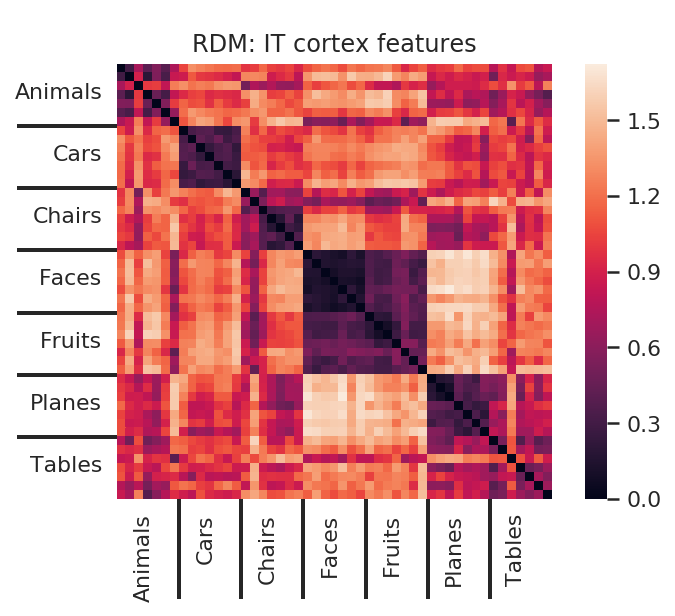

In [17]:
# compute rdm for neural features
neural_rdm = misc.get_rdm(neural_features)

# num class
num_class = 7

# number of objects
num_obj = 49

# number of objects per class
num_obj_per_class = num_obj//num_class

# class and mid class boundaries
mid_class_boundaries = np.arange(num_obj_per_class//2,num_obj_per_class//2 + num_obj,num_obj_per_class)
class_boundaries = np.arange(num_obj_per_class,num_obj,num_obj_per_class)

# class names
class_names = list(data['categ_name_map'].values())

# create plt fig and axis
fig,ax = plt.subplots()

# draw rdm heatmap
sns.heatmap(neural_rdm,ax=ax,square=True)

# set minor x ticks as class names
ax.set_xticks(mid_class_boundaries,minor=True)
ax.set_xticklabels(class_names,minor=True,rotation='vertical')

# set major x ticks as class boundaries
ax.set_xticks(class_boundaries)
ax.set_xticklabels(['']*7)

# set minor y ticks as class names
ax.set_yticks(mid_class_boundaries,minor=True)
ax.set_yticklabels(class_names,minor=True,rotation='horizontal')

# set major y ticks as class boundaries
ax.set_yticks(class_boundaries)
ax.set_yticklabels(['']*7)

# set properties of major ticks for appropriate separation
ax.tick_params(which='major', length=50, width=2, direction='out',bottom=True,left=True)

# set plot title
plt.title('RDM: IT cortex features')

#fig.subplots_adjust(bottom=0.3)
# save and show the plots
fig.savefig('assets/rdm_it_cortex.png',bbox_inches="tight",dpi=300)
plt.show()

## Visualize RDM for different pretrained models

In [18]:
# create model loader instance
model_loader = ModelLoader()

# get all model names
model_names = list(model_loader.get_model_byname.keys())

# directory saving model features
model_feat_path = 'models/model_features/'

# number of rows and columns
nrows,ncols = 5,4

# create subplots
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(100,100))
#fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i,model_name in enumerate(model_names):
    
    # get subplot location
    m,n = i//ncols,i%ncols
    
    # read stored model features
    model_feat_filename = model_feat_path+model_name+'_feat.pkl'
    
    with open(model_feat_filename,'rb') as f:
        model_features = pickle.load(f)
    
    # perform noise correction
    model_features = misc.noise_correction(model_features,neural_features)
    
    # compute model rdm
    model_rdm = misc.get_rdm(model_features)
    
    # plot rdm heatmap
    im = sns.heatmap(model_rdm,ax=axs[m,n],vmin=0,vmax=.5,square=True,cbar=False)
    axs[m,n].set_title(model_name,fontsize=60,pad=20)
    
    # set major x ticks as class boundaries
    axs[m,n].set_xticks(class_boundaries)
    axs[m,n].set_xticklabels(['']*7)
    
    # set major y ticks as class boundaries
    axs[m,n].set_yticks(class_boundaries)
    axs[m,n].set_yticklabels(['']*7)
    
    # set properties of major ticks for appropriate separation
    axs[m,n].tick_params(which='major', length=30, width=5, direction='out',bottom=True,left=True)

# add colorbar to right side of the plot
fig.subplots_adjust(right=0.8)
mappable = im.get_children()[0]
cax = fig.add_axes([0.85,0.2,0.01,0.6]) 
cb = plt.colorbar(mappable, cax = cax)
cb.ax.tick_params(labelsize=60)

# save and show the plots
fig.savefig('assets/rdm_models.png',bbox_inches="tight",dpi=300)
plt.show()